<a href="https://colab.research.google.com/github/Vanshree005/FUTURE_ML_02/blob/main/ml_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd

df =  pd.read_csv('AAPL.csv')
df = df [['Date','Close']]
import datetime
def str_to_datetime(s):
  split =s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
datetime_object = str_to_datetime('1980-12-12')
datetime_object

datetime.datetime(1980, 12, 12, 0, 0)

In [25]:
df['Date']= df['Date'].apply(str_to_datetime)
df['Date']

,Date
0,1980-12-12
1,1980-12-15
2,1980-12-16
3,1980-12-17
4,1980-12-18
...,...
10404,2022-03-18
10405,2022-03-21
10406,2022-03-22
10407,2022-03-23


In [26]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2022-03-18,163.979996
2022-03-21,165.380005
2022-03-22,168.820007


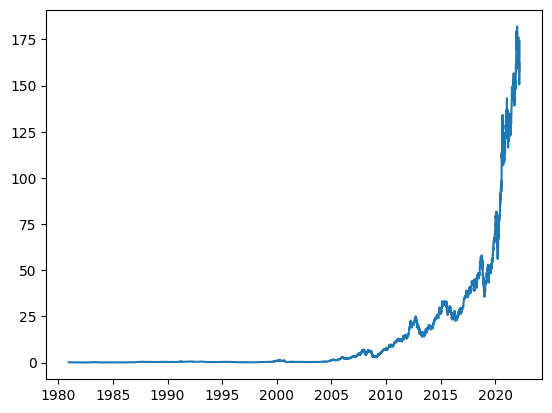

In [27]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])


In [28]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
 first_date = str_to_datetime(first_date_str)
 last_date  = str_to_datetime(last_date_str)

 target_date = first_date
 dates = []
 X, Y = [], []

 last_time = False
 while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

 ret_df = pd.DataFrame({})
 ret_df['Target Date'] = dates

 X = np.array(X)
 for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

 ret_df['Target'] = Y

 return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-24',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,123.389999,122.540001,120.089996,120.589996
1,2021-03-26,122.540001,120.089996,120.589996,121.209999
2,2021-03-29,120.089996,120.589996,121.209999,121.389999
3,2021-03-30,120.589996,121.209999,121.389999,119.900002
4,2021-03-31,121.209999,121.389999,119.900002,122.150002
...,...,...,...,...,...
248,2022-03-18,155.089996,159.589996,160.619995,163.979996
249,2022-03-21,159.589996,160.619995,163.979996,165.380005
250,2022-03-22,160.619995,163.979996,165.380005,168.820007
251,2022-03-23,163.979996,165.380005,168.820007,170.210007


In [29]:
def windowed_df_to_date_x_y(windowed_dataframe):

  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  y = df_as_np[:, -1]

  return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = windowed_df_to_date_x_y(windowed_df)
dates.shape, x.shape, y.shape


((253,), (253, 3, 1), (253,))

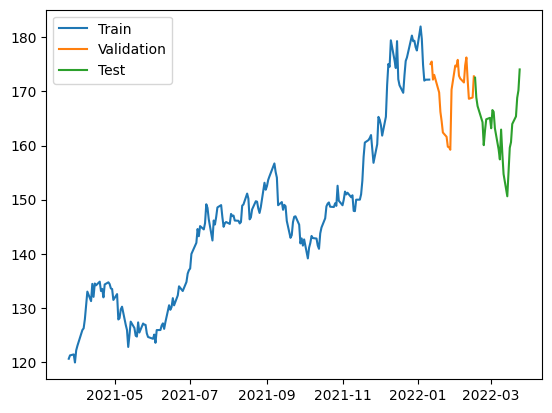

In [30]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]

dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 20862.6934 - mean_absolute_error: 143.6987 - val_loss: 28584.0449 - val_mean_absolute_error: 168.9803
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21204.4648 - mean_absolute_error: 144.8196 - val_loss: 28388.3652 - val_mean_absolute_error: 168.4002
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20885.9883 - mean_absolute_error: 143.7248 - val_loss: 28120.7480 - val_mean_absolute_error: 167.6038
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 20810.0078 - mean_absolute_error: 143.4529 - val_loss: 27794.1016 - val_mean_absolute_error: 166.6265
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20319.2949 - mean_absolute_error: 141.7666 - val_loss: 27410.6484 - val_mean_absolute_error: 165.4719
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19725.7773 - mean_absolute_error: 139.7072 - val_loss: 26912.9883 - val_mean_absolute_error: 163.9611
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


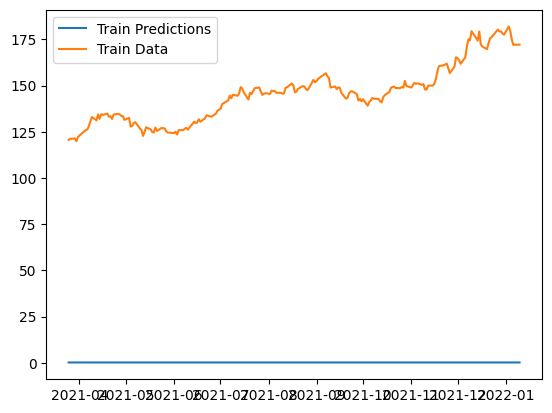

In [33]:
train_predictions = model.predict(x_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Train Predictions', 'Train Data'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


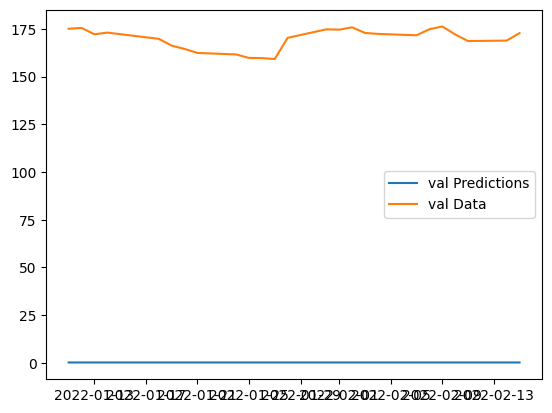

In [32]:
val_predictions = model.predict(x_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['val Predictions', 'val Data'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


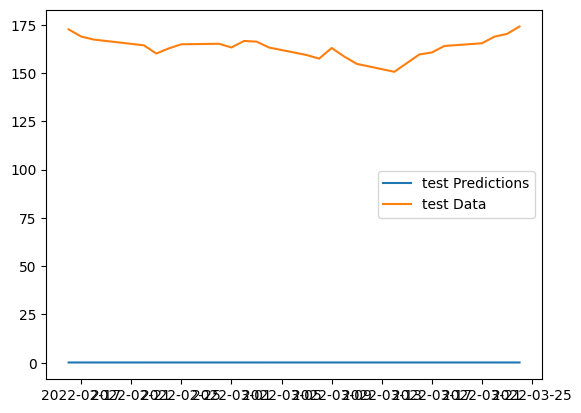

In [34]:
test_predictions = model.predict(x_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['test Predictions', 'test Data'])

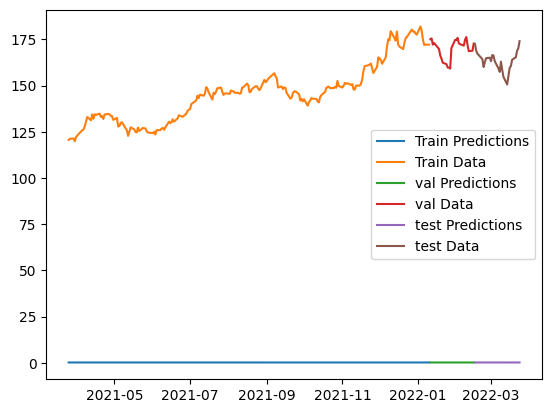

In [35]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Train Predictions', 'Train Data',
    'val Predictions', 'val Data',
    'test Predictions', 'test Data'])

In [38]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(x_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

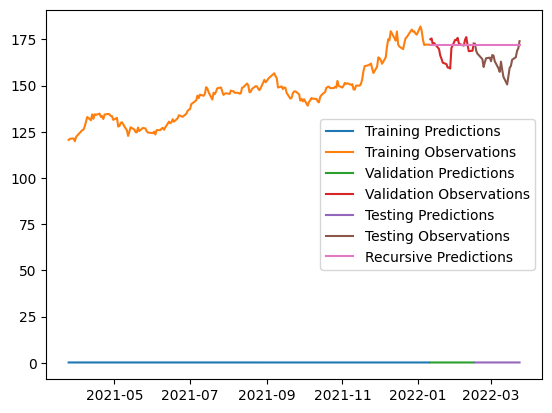

In [39]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])